# MERSCOPE mouse liver

In this notebook, we will use ovrlpy to investigate the [Vizgen MERSCOPE's mouse liver dataset](https://info.vizgen.com/mouse-liver-data).

We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.

## Settings and Imports

First, let's define settings and input files.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import ovrlpy

In [2]:
sample_nr = 1
slice_nr = 1

# TODO: adjust path
data_path = Path("path/to/downloaded_data") / f"Liver{sample_nr}Slice{slice_nr}"

## Loading the data

Next, we want to load the data.

In [3]:
coordinate_df = ovrlpy.io.read_MERSCOPE(data_path / "detected_transcripts.csv")

print(f"Number of transcripts: {len(coordinate_df):,}")

Number of transcripts: 417,243,171


In [4]:
coordinate_df.head()

x,y,z,gene
f64,f64,f64,cat
2506.407,-95.45148,0.0,"""Comt"""
2531.8447,-95.18702,0.0,"""Comt"""
2483.7969,-91.360115,0.0,"""Comt"""
2505.7693,-84.08165,0.0,"""Comt"""
2501.394,-81.38709,0.0,"""Comt"""


### Tissue overview 

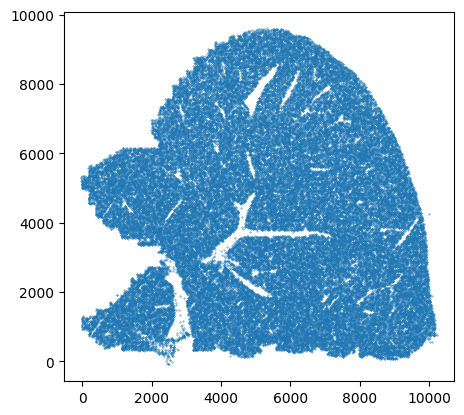

In [5]:
# only show every 5,000th transcript
n = 5_000

fig, ax = plt.subplots()
ax.scatter(coordinate_df[::n, "x"], coordinate_df[::n, "y"], s=0.1)
_ = ax.set(aspect="equal")

## Running the ovrlpy pipeline

ovrlpy provides a convenience function `run` to run the entire pipeline. 
The function creates a signal integrity map, a signal strength map and a Visualizer obejcet to visualize the results.

In [6]:
# ensure reproducibility by setting random_state
# min_distance???
liver = ovrlpy.Ovrlp(coordinate_df, n_components=10, n_workers=8, random_state=42)
liver.analyse()

Running vertical adjustment
Creating gene expression embeddings for visualization
determining pseudocells
found 94105 pseudocells
sampling expression:


100%|██████████| 72/72 [03:33<00:00,  2.96s/it]


Modeling 10 pseudo-celltype clusters;
Creating signal integrity map


100%|██████████| 420/420 [14:50<00:00,  2.12s/it]


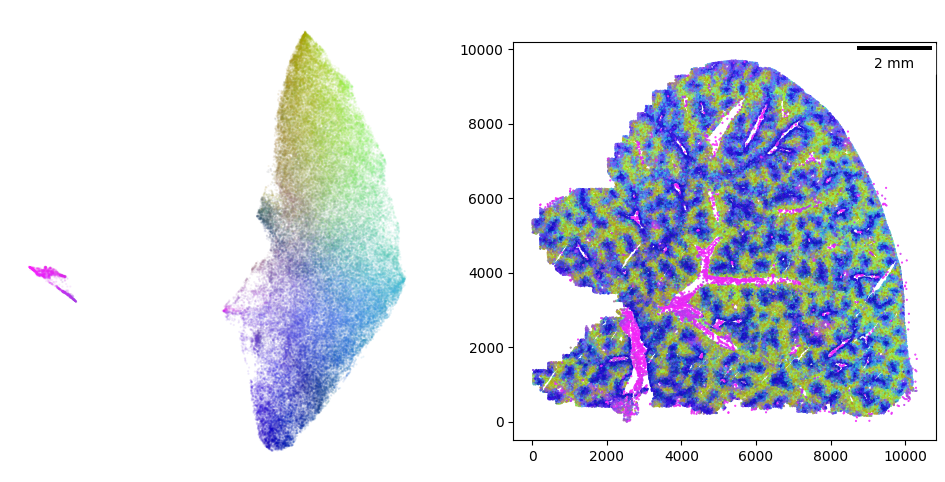

In [7]:
_ = ovrlpy.plot_pseudocells(liver)

### Signal integrity of the liver sample 

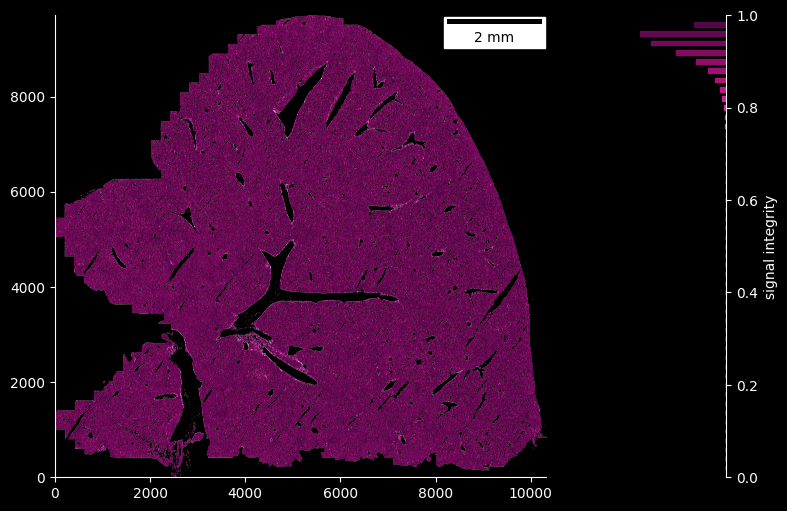

In [8]:
fig = ovrlpy.plot_signal_integrity(liver, signal_threshold=3)

## Doublet probability 

In [9]:
doublets = liver.detect_doublets(min_signal=3, integrity_sigma=3)

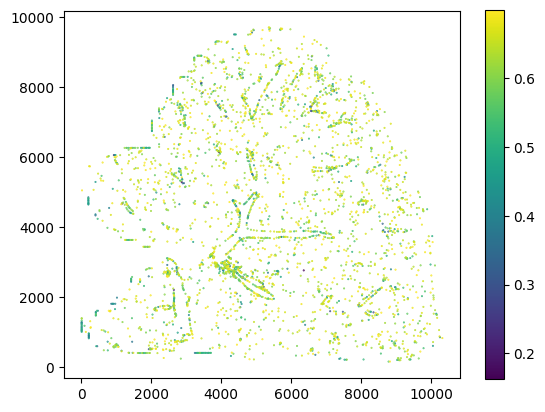

In [10]:
fig, ax = plt.subplots()
_scatter = ax.scatter(
    doublets["x"], doublets["y"], c=doublets["integrity"], s=0.2, cmap="viridis"
)
_ = ax.set_aspect("equal")
_ = fig.colorbar(_scatter, ax=ax)

Visualize a specific doublet event like so.

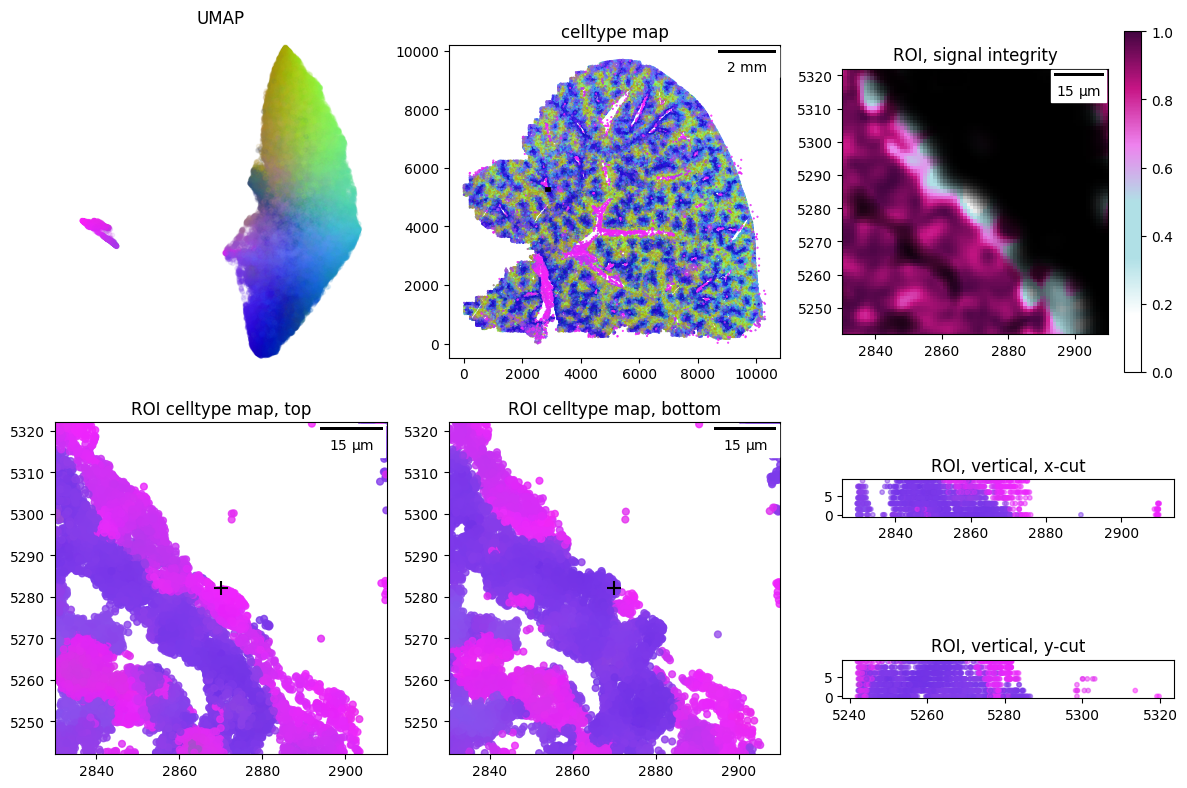

In [11]:
doublet_case = 1

x, y = doublets["x", "y"].row(doublet_case)

_ = ovrlpy.plot_region_of_interest(liver, x, y, window_size=40)